In [2]:
from __future__ import print_function
import google.datalab.bigquery as bq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

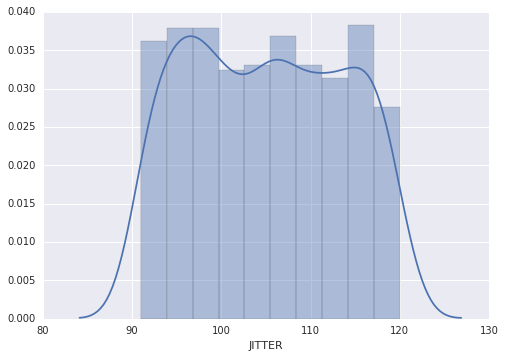

In [70]:
sql = """
SELECT
  CAST(90.5 + RAND()*30 AS INT64) AS JITTER
FROM
  `bigquery-public-data.noaa_gsod.gsod2011`
LIMIT
  1000
"""
df = bq.Query(sql).execute().result().to_dataframe()
sns.distplot(df['JITTER'], kde=True);

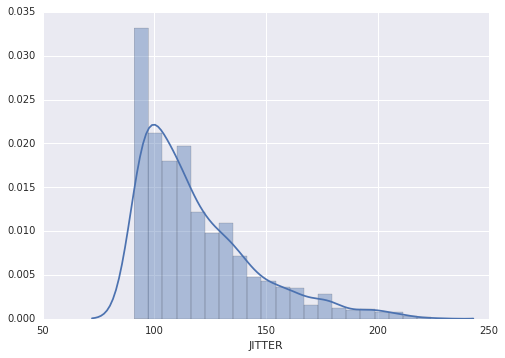

In [72]:
sql = """
SELECT
  CAST(-LN(RAND()*0.99 + 0.01)*30 + 90.5 AS INT64) AS JITTER
FROM
  `bigquery-public-data.noaa_gsod.gsod2011`
LIMIT
  1000
"""
df = bq.Query(sql).execute().result().to_dataframe()
sns.distplot(df['JITTER'], kde=True);

 CREATE TEMPORARY FUNCTION trunc_rand_normal(x FLOAT64, mu FLOAT64, sigma FLOAT64) RETURNS FLOAT64 LANGUAGE js AS "     var u = 1 - Math.random();     var v = 1 - Math.random();     var f = Math.sqrt(-2 * Math.log(u)) * Math.cos(2*Math.PI*v);     f = f * sigma + mu;     if (f < 0)        return 0;     else        return f; "; SELECT   trunc_rand_normal(TEMP, 90, 15) AS JITTER FROM   `bigquery-public-data.noaa_gsod.gsod2011` LIMIT   1000 


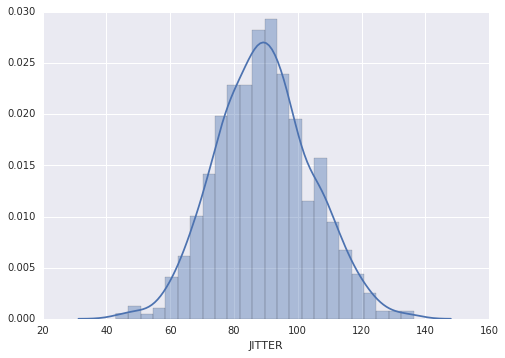

In [75]:
js = """
    var u = 1 - Math.random();
    var v = 1 - Math.random();
    var f = Math.sqrt(-2 * Math.log(u)) * Math.cos(2*Math.PI*v);
    f = f * sigma + mu;
    if (f < 0)
       return 0;
    else
       return f;
""".replace('\n', ' ')
sql = """
CREATE TEMPORARY FUNCTION trunc_rand_normal(x FLOAT64, mu FLOAT64, sigma FLOAT64)
RETURNS FLOAT64
LANGUAGE js AS "{}";
SELECT
  trunc_rand_normal(TEMP, 90, 15) AS JITTER
FROM
  `bigquery-public-data.noaa_gsod.gsod2011`
LIMIT
  1000
""".format(js).replace('\n', ' ')

print(sql)
df = bq.Query(sql).execute().result().to_dataframe()
sns.distplot(df['JITTER'], kde=True);

In [12]:
sql = """
SELECT
  pred, ontime, count(pred) as num_pred, count(ontime) as num_ontime
FROM
  flights2016.eval
Group by pred, ontime
"""
df = bq.Query(sql).execute().result().to_dataframe()

In [13]:
df.head()

,pred,ontime,num_pred,num_ontime
0,0.99,0.0,1778,1778
1,0.54,1.0,13077,13077
2,0.25,1.0,5593,5593
3,0.63,0.0,2220,2220
4,0.41,0.0,2612,2612


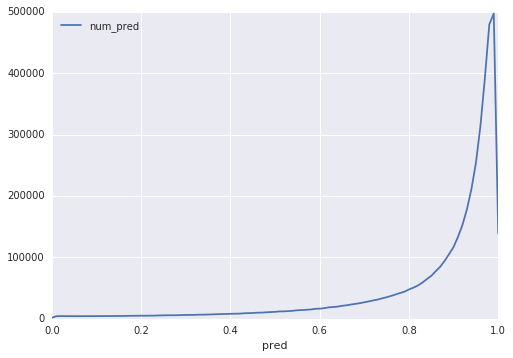

In [14]:
ontime = df[df['ontime'] > 0.5].sort_values(by='pred')
ontime.plot(x='pred', y='num_pred');

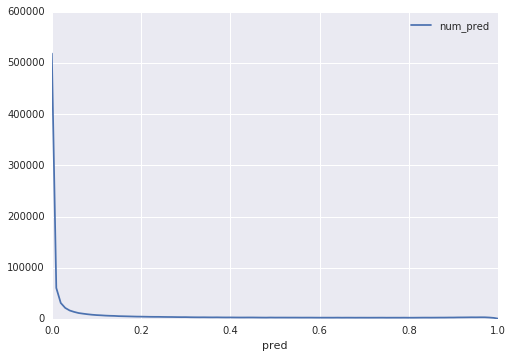

In [15]:
late = df[df['ontime'] < 0.5].sort_values(by='pred')
late.plot(x='pred', y='num_pred');

In [31]:
sql = """
SELECT
  pred, AVG(dep_delay) as dep_delay, AVG(distance) as distance
FROM
  flights2016.eval
GROUP BY pred
"""
df = bq.Query(sql).execute().result().to_dataframe()

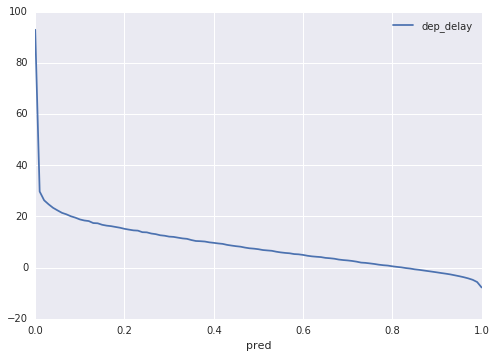

In [32]:
df.sort_values(by='pred').plot(x='pred', y='dep_delay');

In [33]:
sql = """
SELECT
  pred, AVG(dep_delay) as dep_delay
FROM
  flights2016.eval
WHERE (ontime > 0.5 and pred <= 0.5) or (ontime < 0.5 and pred > 0.5)
GROUP BY pred
"""
df = bq.Query(sql).execute().result().to_dataframe()

In [34]:
df.head()

,pred,dep_delay
0,0.14,13.900901
1,0.58,8.469910
2,0.98,-4.694699
3,0.38,8.992415
4,0.43,7.989959


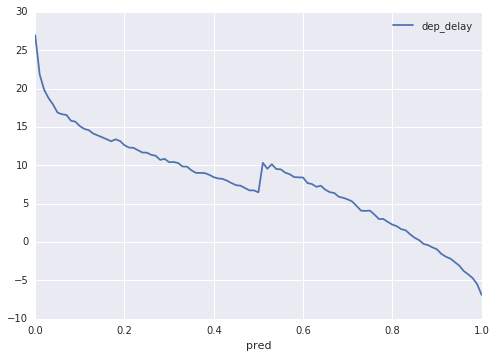

In [35]:
df.sort_values(by='pred').plot(x='pred', y='dep_delay');

In [3]:
sql = """
SELECT
  carrier, pred, AVG(dep_delay) as dep_delay
FROM
  flights2016.eval
WHERE (ontime > 0.5 and pred <= 0.5) or (ontime < 0.5 and pred > 0.5)
GROUP BY pred, carrier
"""
df = bq.Query(sql).execute().result().to_dataframe()

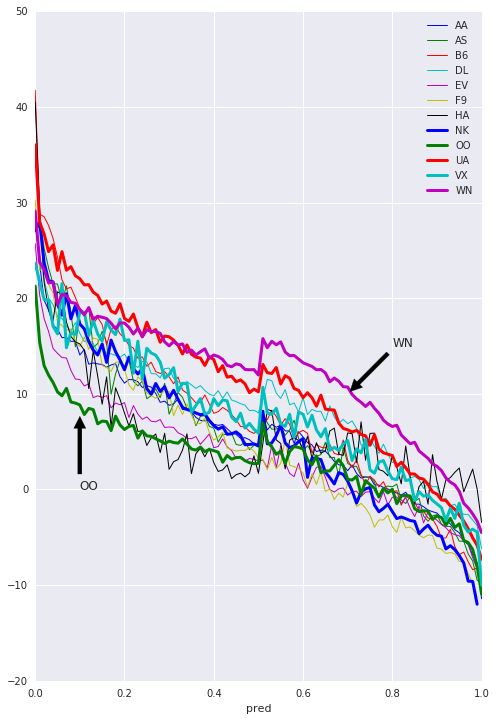

In [22]:
df = df.sort_values(by='pred')
plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'bgrcmykbgrcmyk') +"
                                   "cycler('lw', [1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3])")
fig, ax = plt.subplots(figsize=(8,12))
for label, dfg in df.groupby('carrier'):
    dfg.plot(x='pred', y='dep_delay', ax=ax, label=label)
plt.legend();
ax.annotate('WN', xy=(0.7, 10), xytext=(0.8, 15), arrowprops=dict(facecolor='black', shrink=0.05));
ax.annotate('OO', xy=(0.1, 8), xytext=(0.1, 0), arrowprops=dict(facecolor='black', shrink=0.05));

In [24]:
sql = """
SELECT
  origin,
  dest,
  COUNT(*) as num_flights
FROM
  flights2016.eval
WHERE
  carrier = 'OO'
GROUP BY
  origin,
  dest
order by num_flights desc limit 10
"""
df = bq.Query(sql).execute().result().to_dataframe()
df.head()

,origin,dest,num_flights
0,ORD,MKE,4527
1,MKE,ORD,4525
2,LAX,SAN,2755
3,SAN,LAX,2742
4,SFO,ONT,2612


In [63]:
sql = """
SELECT
  APPROX_QUANTILES(TIMESTAMP_DIFF(CRS_ARR_TIME, CRS_DEP_TIME, SECOND),5) AS times
FROM
  flights2016.simevents
WHERE
  carrier = 'OO' and origin = 'ORD' and dest = 'MKE'
"""
df2016 = bq.Query(sql).execute().result().to_dataframe()
df2016.head()

,times
0,"[2580, 2820, 2880, 2940, 3180, 89700]"


In [64]:
sql = """
SELECT
  APPROX_QUANTILES(TIMESTAMP_DIFF(CRS_ARR_TIME, CRS_DEP_TIME, SECOND),5) AS times
FROM
  flights.simevents
WHERE
  carrier = 'OO' and origin = 'ORD' and dest = 'MKE'
"""
df2015 = bq.Query(sql).execute().result().to_dataframe()
df2015.head()

,times
0,"[2400, 2760, 2880, 3060, 3300, 90240]"
